In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

windows = False # If on mac put false, windows true

Can i write something which checks if it is stable? Say check the difference between the final two values say?  
have a feeling there will be an error some where. maybe the way i calculate the resistance shouldnt be for all. think about the C line.  
have worked out that it has to be under 3 delay with any alpha value.

#### data input

In [23]:
if windows == True:
    baselines = pd.read_csv(r"C:\Users\timst\Onedrive - Nexus365\4YP\python\_storage\baselines.csv", index_col=0).rename(columns={"Q in single(m^3/s????)": "baseline Q"}) # FOR WINDOWS
else:
    baselines = pd.read_csv(r"/Users/Debs/OneDrive - Nexus365/4YP/python/_storage/baselines.csv", index_col=0).rename(columns={"Q in single(m^3/s????)": "baseline Q"}) # FOR MAC

#### paramaters

In [24]:
optimised_value_tau = 2.292929292929293
phi_min_baseline = 0.153
n=1
max_time = 80
no = 1001
delay_pressure_drop = 15
alpha_t = 2.6e-5 # from payne paper, solutbility coeff of oxygen in brain tissue

H = 0.42 #no units,ratio #Hematocrit assumed to be constant
M = 30* 10e-9 #mol_ O2/(mL/s) #Taken from table 2 from Wiley Payne paper
cHb = 0.2 #mL_O2/mL #Taken from table 2 from Wiley Payne paper
paO2_bar_t = 15 #mmHG #Taken from table 2 from Wiley Payne paper
K = 5*10e-8 # mL/(m/s/mmHg)  From table 2 wiley payne paper

#### work out vectors

In [26]:
t = pd.Series(np.linspace(0,max_time,no))
dt = max_time/(no-1)

#### PRessure stuff
pressure_in = pd.Series(np.zeros(len(t)))
ratio_drop = 0.5
for i in range(len(t)):
    if t[i] <= delay_pressure_drop:
        pressure_in[i] = 60
    else:
        pressure_in[i] = 60 - 34.18*ratio_drop
pressure_out = pd.Series(np.zeros(len(t))) + 60 - 34.18
pressure_difference = pressure_in - pressure_out

print('Time of simulation :',max_time,'seconds')
print('Time step :',dt,'seconds')
print('Number of iterations:',no)

Time of simulation : 80 seconds
Time step : 0.08 seconds
Number of iterations: 1001


## Model

#### Functions

In [27]:
def total_R(baselines,phi,alpha):
    C_ = alpha*(baselines.loc[6,'Resistance for Q']/2)/phi**4  + (1-alpha)*(baselines.loc[6,'Resistance for Q']/2)
    C_6 = (C_ + baselines.loc[5,'Resistance for Q'] + baselines.loc[7,'Resistance for Q'])/2
    C_65 = (C_6 + baselines.loc[4,'Resistance for Q'] + baselines.loc[8,'Resistance for Q'])/2
    C_654 = (C_65 + baselines.loc[3,'Resistance for Q'] + baselines.loc[9,'Resistance for Q'])/2
    C_6543 = (C_654 + baselines.loc[2,'Resistance for Q'] + baselines.loc[10,'Resistance for Q'])/2
    C_65432 = (C_6543 + baselines.loc[1,'Resistance for Q'] + baselines.loc[11,'Resistance for Q'])/2
    C_654321 = C_65432 + baselines.loc[0,'Resistance for Q'] + baselines.loc[12,'Resistance for Q']
    R_total = C_654321
    return R_total
 
def euler(alpha,delay):
    delay_number = round(delay/dt)
    
    R_tot = pd.Series(np.zeros(len(t)))
    Q_tot = pd.Series(np.zeros(len(t)))
    Q_norm = pd.Series(np.ones(len(t)))
    
    phi = pd.Series(np.ones(no))
    phi_min = pd.Series(np.ones(no))
    dphidt = pd.Series(np.zeros(no))
    
    for i in range(len(t)):
        
        if i >=delay_number: 
            R_tot[i] = total_R(baselines,phi[i],alpha)
            Q_tot[i] = pressure_difference[i]/R_tot[i]
            Q_norm[i] = Q_tot[i] / baselines['baseline Q'][0]
            dphidt[i] =  (1/optimised_value_tau)*( -phi[i-delay_number] + Q_norm[i]*(1-phi_min[i]) + phi_min[i] )
            phi[i+1] = dphidt[i]*dt + phi[i]
            phi_min[i+1] = 1-alpha*(1-phi_min_baseline)*(1-Q_norm[i])**n
            
    combined = pd.DataFrame()
    combined['t'] = t
    combined['pressure_difference'] = pressure_difference
    combined['phi'] = phi
    combined['phi_min'] = phi_min
    combined['dphidt'] = dphidt
    combined['R_tot'] = R_tot
    combined['Q_tot'] = Q_tot
    combined['Q_norm'] = Q_norm
            
    return combined

#### the loop

In [43]:
# response = {}

# alpha = np.linspace(0,1,num=10)
# delay = np.linspace(2.99,3, num=10)

# for i in range(len(alpha)):
#     for j in range(len(delay)):
        #first is alpha second is delay
#             response[i,j] = euler(alpha[i],delay[j])

alpha = 0.5
delay = 2.99
out = euler(alpha,delay)

#### Vessel details
In order to find the partials in tissue, we need to find the vessel details at each time step. As before we were just considering it as a whole to find some parameters for our capillaries.  
another idea i have had is that you could just take the end values, but this doesnt seem as full proof a method tbh. will be able to get some good plots from this.
/n
whats going on with viscocity?
/n
need to update the resistances, pressure drop, resiatnces for Q, IN ORDER TO CHANGE partial pressure blood therefore partial pressure tissues  
saturations maybe, 

basically need to speak to payne to find out what stuff stays constant and what changes.


the reason why my resistances seem to be twice as big. as in the equation i am finding it for both capillaries. however in the table i save it for a single one. why its double

In [44]:
def check_imag_roots_real(all_roots):
    counter = 0
    sols = 0
    for i in range(len(all_roots)):
        if all_roots[i].imag <= 10e-13 and all_roots[i].imag >= -10e-13:
            sols = all_roots[i].real
            counter += 1
    if counter != 1:
        print('Something seems wrong with the partial presure to Saturation cubic solver as not one solution is returned.')
    return sols

In [45]:
# Initialise Data, set up DFs
baseline = baselines.drop(['Viscocity(mPAs)','Resistance for U', 'U in single(m/s????)'],axis=1)
constant = baseline.drop(['baseline Q','Pressure Drop(mmHg)','Saturation in','Saturation out','Resistance for Q','dS','Saturation ave','partial pressure blood(mmHg)','X-Area wall(mm^2?)','wall thickness(µm)','tissue partials(mmHg)'], axis=1)
vessel_data_alltime = {}
terms_alltime = {}

for i in range(len(t)):
    
    # 
    if i ==0:
        step = baseline.copy()
        step['dptdt'] = 0
    else:       
        step = vessel_data_alltime[i-1].copy()
        step['tissue partials(mmHg)'] = vessel_data_alltime[i-1]['tissue partials(mmHg)'] + vessel_data_alltime[i-1]['dptdt']*dt
        step['Saturation out'] = vessel_data_alltime[i-1]['Saturation out'] + vessel_data_alltime[i-1]['dSoutdt']*dt
        step['Saturation in'] = vessel_data_alltime[i-1]['Saturation in'] + vessel_data_alltime[i-1]['dSindt']*dt
        
    step.loc[6,'Diameter(µm)'] = baseline.loc[6,'Diameter(µm)']*out.loc[i,'phi']    
    step.loc[6,'X-Area wall(mm^2?)'] = np.pi * ( 0.16*(step.loc[6,'Diameter(µm)'])**2 + 1.4*(step.loc[6,'Diameter(µm)']) + 14 )
    step.loc[6,'wall thickness(µm)'] = ( -(step.loc[6,'Diameter(µm)']) + np.sqrt((step.loc[6,'Diameter(µm)'])**2 + (4*(step.loc[6,'X-Area wall(mm^2?)'])/np.pi))) / 2
    step['Saturation ave'] = (step['Saturation in']+step['Saturation out'])/2
    
    for j in range(len(step['Saturation ave'])):
        root_temp = None
        sols = 0
        root_temp = np.roots([1,0,150,23400*step.loc[j,'Saturation ave']/(step.loc[j,'Saturation ave']-1)]) #gives mmHg , *133.322
        sols = check_imag_roots_real(root_temp) 
        #sols = sols*133.322 ###Remove this step if want in mmHg
        step.loc[j,'partial pressure blood(mmHg)'] = sols
    
    step['Q'] = np.empty
#     terms = pd.DataFrame()
#     terms['2divVb','pre_p_s','p_diff','Q_S_diff','dSindt'] = np.empty
    terms = pd.DataFrame({'Name': ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'C', 'V6', 'V5', 'V4', 'V3', 'V2', 'V1']})
#     terms['twodivVb','pre_p_s','p_diff','Q_S_diff','dSindt'] = np.empty
     
    
    #Could pull the Q stuff all out and do it seperately from this bit.
    for j in range(len(step)):
        if j ==0:
            step.loc[j,'dSindt'] = 0
            step.loc[j,'Q'] = out.loc[i,'Q_tot']
        else:
            step.loc[j,'dSindt'] = step.loc[j-1,'dSoutdt']
            if j <=  6:
                step.loc[j,'Q'] = step.loc[j-1,'Q']/2
            else:
                step.loc[j,'Q'] = step.loc[j-1,'Q']*2
        
        terms.loc[j,'twodivVb'] = 2/(np.pi*((step.loc[j,'Diameter(µm)']**2)/4)*step.loc[j,'Length(µm)'])  # micro meters ^ -3
        terms.loc[j,'pre_p_s'] = (2 * np.pi * K * (step.loc[j,'Diameter(µm)']/2) * constant.loc[j,'Length(µm)'])/(step.loc[j,'wall thickness(µm)']*cHb*H)
        terms.loc[j,'p_diff'] = step.loc[j,'partial pressure blood(mmHg)']-step.loc[j,'tissue partials(mmHg)']
        terms.loc[j,'Q_S_diff'] = step.loc[j,'Q']*(step.loc[j,'Saturation out']-step.loc[j,'Saturation in'])
        terms.loc[j,'dSindt'] = step.loc[j,'dSindt']
        
        step.loc[j,'dSoutdt'] = terms.loc[j,'twodivVb'] * ( - terms.loc[j,'pre_p_s'] * terms.loc[j,'p_diff'] - terms.loc[j,'Q_S_diff'] ) - terms.loc[j,'dSindt']
    terms['dSoutdt'] = step['dSoutdt'].copy()

#         step.loc[j,'dSoutdt'] = (2/(np.pi*((step.loc[j,'Diameter(µm)']**2)/4)*step.loc[j,'Length(µm)']))*(-((2 * np.pi * K * (step.loc[j,'Diameter(µm)']/2) * constant.loc[j,'Length(µm)'])/(step.loc[j,'wall thickness(µm)']*cHb*H))*(step.loc[j,'partial pressure blood(mmHg)']-step.loc[j,'tissue partials(mmHg)']) - step.loc[j,'Q']*(step.loc[j,'Saturation out']-step.loc[j,'Saturation in'])) - step.loc[j,'dSindt']

        #Incase i want to do something with alpha to the capillary one. dont think i need to.
#         if j==6:           
#             step.loc[j,'dSoutdt'] = (2/(np.pi*((step.loc[j,'Diameter(µm)']**2)/4)*step.loc[j,'Length(µm)']))*(((2 * np.pi * K * (step.loc[j,'Diameter(µm)']/2) * constant.loc[j,'Length(µm)'])/(step.loc[j,'wall thickness(µm)']*cHb*H))*(step.loc[j,'partial pressure blood(mmHg)']-step.loc[j,'tissue partials(mmHg)']) - step.loc[j,'Q']*(step.loc[j,'Saturation out']-step.loc[j,'Saturation in'])) - step.loc[j,'dSindt']
#         else:
#             step.loc[j,'dSoutdt'] = (2/(np.pi*((step.loc[j,'Diameter(µm)']**2)/4)*step.loc[j,'Length(µm)']))*((2 * np.pi * K * (step.loc[j,'Diameter(µm)']/2) * constant.loc[j,'Length(µm)'])/(step.loc[j,'wall thickness(µm)']*cHb*H)*(step.loc[j,'partial pressure blood(mmHg)']-step.loc[j,'tissue partials(mmHg)']) - step.loc[j,'Q']*(step.loc[j,'Saturation out']-step.loc[j,'Saturation in'])) - step.loc[j,'dSindt']

    terms['onedivalphaV'] = 1/(alpha_t*constant['Vt'])
    terms['pre_p_p'] = (2 * np.pi * K * (step['Diameter(µm)']/2) * constant['Length(µm)'])/(step['wall thickness(µm)'])
    terms['MVt'] = M * constant['Vt']
    
    step['dptdt'] = terms['onedivalphaV']*(terms['pre_p_p']*terms['p_diff'] - terms['MVt'])
    terms['dptdt'] = step['dptdt'].copy()
    
#     step['dptdt'] = (1/(alpha_t*vessel_values_general['Vt']))*((2 * np.pi * K * (step['Diameter(µm)']/2) * vessel_values_general['Length(µm)'])*(vessel_values_general['partial pressure blood(mmHg)'] - step['tissue partials(mmHg)'])/( step['wall thickness(µm)']) - M * vessel_values_general['Vt'])

    if i == 400 or i ==800:
        display(step)
        display(terms)
    terms_alltime[i] = terms
    vessel_data_alltime[i] = step

,Name,Number,Diameter(µm),Length(µm),Pressure Drop(mmHg),Saturation in,Saturation out,Resistance for Q,baseline Q,dS,Saturation ave,Vt,partial pressure blood(mmHg),X-Area wall(mm^2?),wall thickness(µm),tissue partials(mmHg),dptdt,Q,dSindt,dSoutdt
0,A1,1,23.970000,1267.6,6.93,0.940000,0.929989,0.248752,27.859025,0.0100,0.934994,78005.271056,68.840947,438.213672,4.841407,66.469176,-9.926449e-06,13.4472,0.000000e+00,-5.025265e-07
1,A2,2,19.170000,930.3,5.87,0.929989,0.919999,0.421004,13.942870,0.0100,0.924994,39040.035790,65.325852,313.016429,4.253658,63.549234,-1.154998e-05,6.72358,-5.025265e-07,-3.469579e-08
2,A3,4,15.280000,543.6,4.02,0.919999,0.889952,0.576945,6.967734,0.0300,0.904976,58528.968018,59.803250,228.546291,3.810683,54.680596,-1.267446e-05,3.36179,-3.469579e-08,-2.127984e-06
3,A4,8,12.080000,302.3,2.70,0.889952,0.839931,0.775060,3.483601,0.0500,0.864941,48770.419868,52.174948,170.463521,3.485850,43.292595,-1.151043e-05,1.6809,-2.127984e-06,-3.063053e-06
4,A5,16,9.460000,161.2,1.82,0.839931,0.764804,1.049713,1.733807,0.0750,0.802368,36409.953497,44.533710,130.572935,3.265971,29.653740,-9.975262e-06,0.840448,-3.063053e-06,-8.725452e-06
5,A6,32,7.320000,154.7,2.35,0.764804,0.664885,2.700295,0.870275,0.1000,0.714844,24367.708781,37.568794,103.110791,3.138293,24.681308,-9.028057e-06,0.420224,-8.725452e-06,-5.089804e-06
6,C,64,6.790749,243.9,2.62,0.664885,0.610069,6.016773,0.435449,0.0550,0.637477,6705.920215,33.076091,97.029129,3.117221,30.976697,-1.488974e-03,0.210112,-5.089804e-06,2.974764e-06
7,V6,32,11.510000,473.9,1.27,0.610069,0.597426,1.463178,0.867974,0.0125,0.603747,3037.907970,31.394885,161.197683,3.433626,31.029737,-2.585954e-06,0.420224,2.974764e-06,-3.199245e-06
8,V5,16,14.530000,272.3,0.61,0.597426,0.587565,0.348476,1.750477,0.0100,0.592495,4901.336835,30.861484,214.009514,3.730525,29.979048,-2.367462e-06,0.840448,-3.199245e-06,2.791143e-06
9,V4,8,17.790000,426.6,0.89,0.587565,0.582432,0.256826,3.465382,0.0050,0.584998,4851.535027,30.512803,281.309064,4.092089,30.013259,-1.466713e-06,1.6809,2.791143e-06,-2.955171e-06


,Name,twodivVb,pre_p_s,p_diff,Q_S_diff,dSindt,dSoutdt,onedivalphaV,pre_p_p,MVt,dptdt
0,A1,0.000003,0.117360,2.371772,-0.134624,0.000000e+00,-5.025265e-07,0.493063,0.009858,0.023402,-9.926449e-06
1,A2,0.000007,0.078401,1.776618,-0.067165,-5.025265e-07,-3.469579e-08,0.985182,0.006586,0.011712,-1.154998e-05
2,A3,0.000020,0.040761,5.122653,-0.101012,-3.469579e-08,-2.127984e-06,0.657137,0.003424,0.017559,-1.267446e-05
3,A4,0.000058,0.019590,8.882354,-0.084080,-2.127984e-06,-3.063053e-06,0.788624,0.001646,0.014631,-1.151043e-05
4,A5,0.000177,0.008731,14.879970,-0.063140,-3.063053e-06,-8.725452e-06,1.056347,0.000733,0.010923,-9.975262e-06
5,A6,0.000307,0.006748,12.887486,-0.041989,-8.725452e-06,-5.089804e-06,1.578381,0.000567,0.007310,-9.028057e-06
6,C,0.000226,0.009936,2.099394,-0.011517,-5.089804e-06,2.974764e-06,5.735460,0.000835,0.002012,-1.488974e-03
7,V6,0.000041,0.029706,0.365149,-0.005313,2.974764e-06,-3.199245e-06,12.660534,0.002495,0.000911,-2.585954e-06
8,V5,0.000044,0.019833,0.882437,-0.008288,-3.199245e-06,2.791143e-06,7.847153,0.001666,0.001470,-2.367462e-06
9,V4,0.000019,0.034681,0.499544,-0.008628,2.791143e-06,-2.955171e-06,7.927705,0.002913,0.001455,-1.466713e-06


,Name,Number,Diameter(µm),Length(µm),Pressure Drop(mmHg),Saturation in,Saturation out,Resistance for Q,baseline Q,dS,Saturation ave,Vt,partial pressure blood(mmHg),X-Area wall(mm^2?),wall thickness(µm),tissue partials(mmHg),dptdt,Q,dSindt,dSoutdt
0,A1,1,23.970000,1267.6,6.93,0.940000,0.929973,0.248752,27.859025,0.0100,0.934986,78005.271056,68.837884,438.213672,4.841407,66.468655,-0.000022,13.639,0.000000e+00,-4.940118e-07
1,A2,2,19.170000,930.3,5.87,0.929973,0.919998,0.421004,13.942870,0.0100,0.924985,39040.035790,65.323120,313.016429,4.253658,63.548636,-0.000025,6.81948,-4.940118e-07,-3.557973e-08
2,A3,4,15.280000,543.6,4.02,0.919998,0.889885,0.576945,6.967734,0.0300,0.904941,58528.968018,59.795110,228.546291,3.810683,54.679919,-0.000029,3.40974,-3.557973e-08,-2.087568e-06
3,A4,8,12.080000,302.3,2.70,0.889885,0.839834,0.775060,3.483601,0.0500,0.864859,48770.419868,52.162287,170.463521,3.485850,43.291975,-0.000027,1.70487,-2.087568e-06,-3.017699e-06
4,A5,16,9.460000,161.2,1.82,0.839834,0.764528,1.049713,1.733807,0.0750,0.802181,36409.953497,44.515420,130.572935,3.265971,29.653200,-0.000024,0.852435,-3.017699e-06,-8.557599e-06
5,A6,32,7.320000,154.7,2.35,0.764528,0.664723,2.700295,0.870275,0.1000,0.714626,24367.708781,37.554439,103.110791,3.138293,24.680820,-0.000021,0.426217,-8.557599e-06,-5.059831e-06
6,C,64,7.174491,243.9,2.62,0.664723,0.610163,6.016773,0.435449,0.0550,0.637443,6705.920215,33.074324,101.410675,3.132007,30.943967,-0.000815,0.213109,-5.059831e-06,2.903657e-06
7,V6,32,11.510000,473.9,1.27,0.610163,0.597325,1.463178,0.867974,0.0125,0.603744,3037.907970,31.394716,161.197683,3.433626,31.029622,-0.000004,0.426217,2.903657e-06,-3.121635e-06
8,V5,16,14.530000,272.3,0.61,0.597325,0.587652,0.348476,1.750477,0.0100,0.592489,4901.336835,30.861179,214.009514,3.730525,29.978930,-0.000005,0.852435,-3.121635e-06,2.711812e-06
9,V4,8,17.790000,426.6,0.89,0.587652,0.582339,0.256826,3.465382,0.0050,0.584996,4851.535027,30.512685,281.309064,4.092089,30.013191,-0.000003,1.70487,2.711812e-06,-2.867676e-06


,Name,twodivVb,pre_p_s,p_diff,Q_S_diff,dSindt,dSoutdt,onedivalphaV,pre_p_p,MVt,dptdt
0,A1,0.000003,0.117360,2.369229,-0.136761,0.000000e+00,-4.940118e-07,0.493063,0.009858,0.023402,-0.000022
1,A2,0.000007,0.078401,1.774485,-0.068022,-4.940118e-07,-3.557973e-08,0.985182,0.006586,0.011712,-0.000025
2,A3,0.000020,0.040761,5.115191,-0.102679,-3.557973e-08,-2.087568e-06,0.657137,0.003424,0.017559,-0.000029
3,A4,0.000058,0.019590,8.870312,-0.085330,-2.087568e-06,-3.017699e-06,0.788624,0.001646,0.014631,-0.000027
4,A5,0.000177,0.008731,14.862220,-0.064193,-3.017699e-06,-8.557599e-06,1.056347,0.000733,0.010923,-0.000024
5,A6,0.000307,0.006748,12.873619,-0.042539,-8.557599e-06,-5.059831e-06,1.578381,0.000567,0.007310,-0.000021
6,C,0.000203,0.010448,2.130356,-0.011627,-5.059831e-06,2.903657e-06,5.735460,0.000878,0.002012,-0.000815
7,V6,0.000041,0.029706,0.365094,-0.005471,2.903657e-06,-3.121635e-06,12.660534,0.002495,0.000911,-0.000004
8,V5,0.000044,0.019833,0.882248,-0.008245,-3.121635e-06,2.711812e-06,7.847153,0.001666,0.001470,-0.000005
9,V4,0.000019,0.034681,0.499494,-0.009059,2.711812e-06,-2.867676e-06,7.927705,0.002913,0.001455,-0.000003


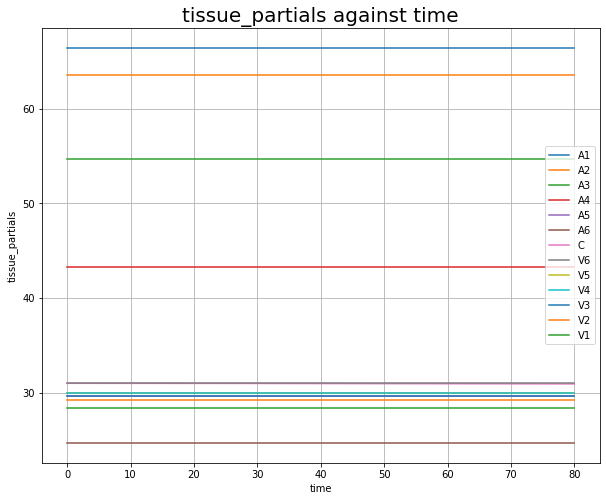

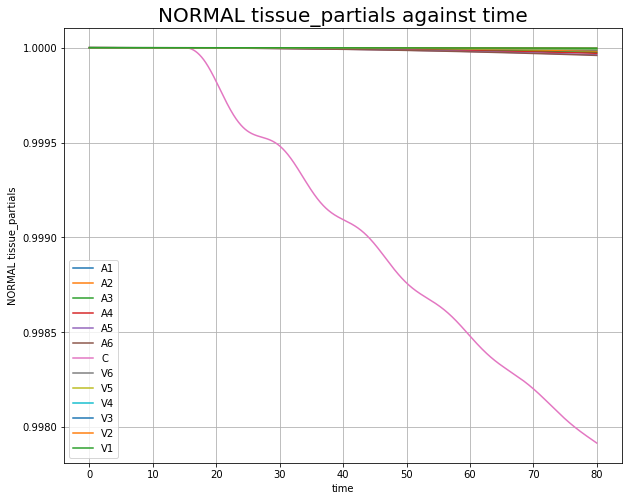

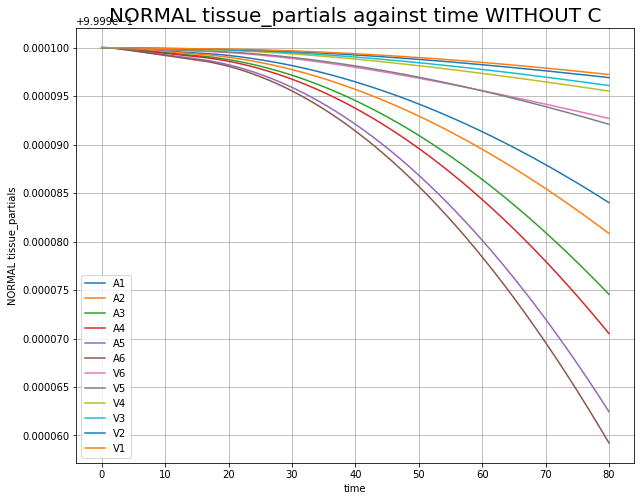

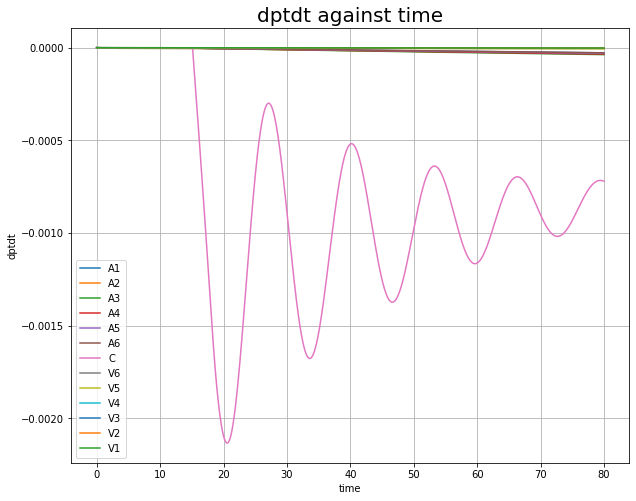

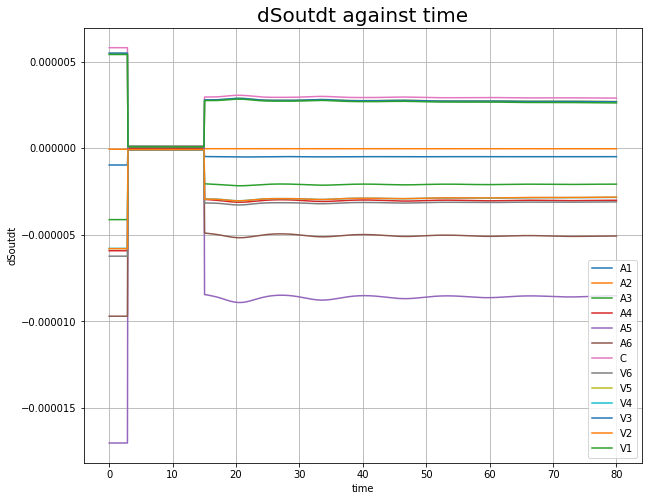

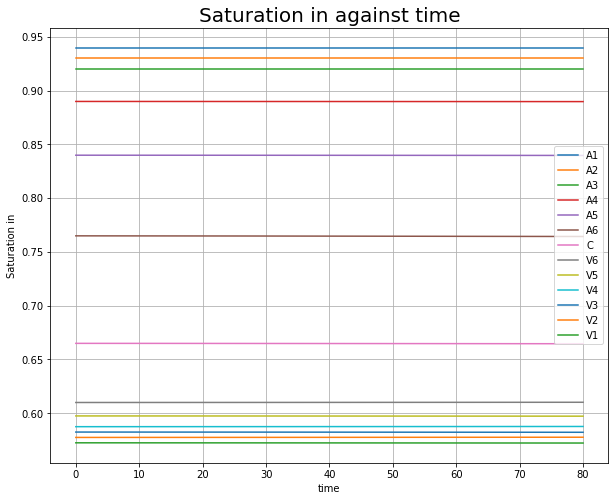

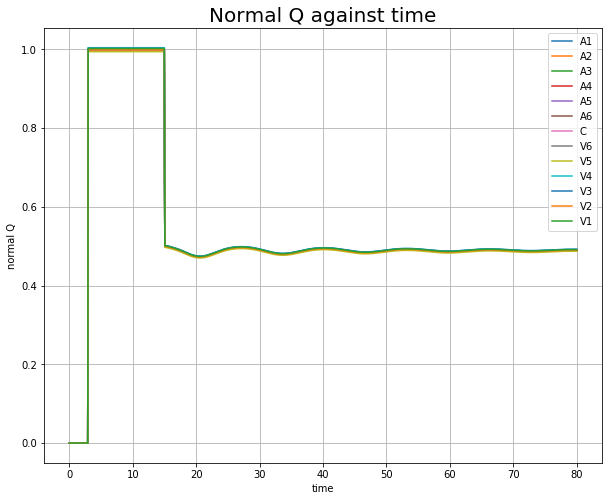

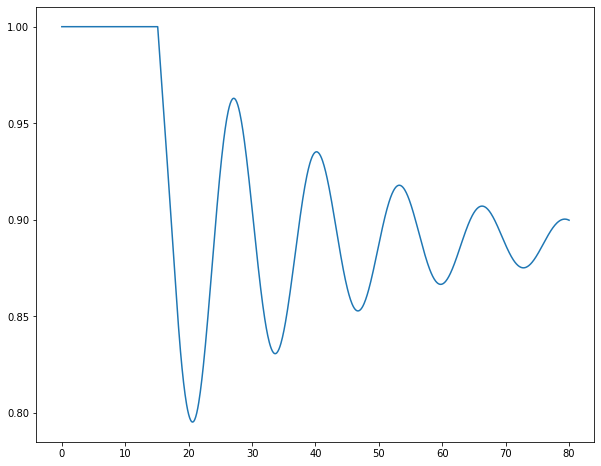

In [46]:
tissue_partials = pd.DataFrame({'A1': np.zeros(len(vessel_data_alltime)), 'A2': np.zeros(len(vessel_data_alltime)), 'A3': np.zeros(len(vessel_data_alltime)), 'A4': np.zeros(len(vessel_data_alltime)), 'A5': np.zeros(len(vessel_data_alltime)), 'A6': np.zeros(len(vessel_data_alltime)), 'C': np.zeros(len(vessel_data_alltime)), 'V6': np.zeros(len(vessel_data_alltime)), 'V5': np.zeros(len(vessel_data_alltime)), 'V4': np.zeros(len(vessel_data_alltime)), 'V3': np.zeros(len(vessel_data_alltime)),
           'V2':np.zeros(len(vessel_data_alltime)), 'V1': np.zeros(len(vessel_data_alltime))})
tissue_partials_normal = pd.DataFrame({'A1': np.zeros(len(vessel_data_alltime)), 'A2': np.zeros(len(vessel_data_alltime)), 'A3': np.zeros(len(vessel_data_alltime)), 'A4': np.zeros(len(vessel_data_alltime)), 'A5': np.zeros(len(vessel_data_alltime)), 'A6': np.zeros(len(vessel_data_alltime)), 'C': np.zeros(len(vessel_data_alltime)), 'V6': np.zeros(len(vessel_data_alltime)), 'V5': np.zeros(len(vessel_data_alltime)), 'V4': np.zeros(len(vessel_data_alltime)), 'V3': np.zeros(len(vessel_data_alltime)),
           'V2':np.zeros(len(vessel_data_alltime)), 'V1': np.zeros(len(vessel_data_alltime))})
dptdt = pd.DataFrame({'A1': np.zeros(len(vessel_data_alltime)), 'A2': np.zeros(len(vessel_data_alltime)), 'A3': np.zeros(len(vessel_data_alltime)), 'A4': np.zeros(len(vessel_data_alltime)), 'A5': np.zeros(len(vessel_data_alltime)), 'A6': np.zeros(len(vessel_data_alltime)), 'C': np.zeros(len(vessel_data_alltime)), 'V6': np.zeros(len(vessel_data_alltime)), 'V5': np.zeros(len(vessel_data_alltime)), 'V4': np.zeros(len(vessel_data_alltime)), 'V3': np.zeros(len(vessel_data_alltime)),
           'V2':np.zeros(len(vessel_data_alltime)), 'V1': np.zeros(len(vessel_data_alltime))})
dSoutdt = pd.DataFrame({'A1': np.zeros(len(vessel_data_alltime)), 'A2': np.zeros(len(vessel_data_alltime)), 'A3': np.zeros(len(vessel_data_alltime)), 'A4': np.zeros(len(vessel_data_alltime)), 'A5': np.zeros(len(vessel_data_alltime)), 'A6': np.zeros(len(vessel_data_alltime)), 'C': np.zeros(len(vessel_data_alltime)), 'V6': np.zeros(len(vessel_data_alltime)), 'V5': np.zeros(len(vessel_data_alltime)), 'V4': np.zeros(len(vessel_data_alltime)), 'V3': np.zeros(len(vessel_data_alltime)),
           'V2':np.zeros(len(vessel_data_alltime)), 'V1': np.zeros(len(vessel_data_alltime))})
Saturation_in = pd.DataFrame({'A1': np.zeros(len(vessel_data_alltime)), 'A2': np.zeros(len(vessel_data_alltime)), 'A3': np.zeros(len(vessel_data_alltime)), 'A4': np.zeros(len(vessel_data_alltime)), 'A5': np.zeros(len(vessel_data_alltime)), 'A6': np.zeros(len(vessel_data_alltime)), 'C': np.zeros(len(vessel_data_alltime)), 'V6': np.zeros(len(vessel_data_alltime)), 'V5': np.zeros(len(vessel_data_alltime)), 'V4': np.zeros(len(vessel_data_alltime)), 'V3': np.zeros(len(vessel_data_alltime)),
           'V2':np.zeros(len(vessel_data_alltime)), 'V1': np.zeros(len(vessel_data_alltime))})
Q = pd.DataFrame({'A1': np.zeros(len(vessel_data_alltime)), 'A2': np.zeros(len(vessel_data_alltime)), 'A3': np.zeros(len(vessel_data_alltime)), 'A4': np.zeros(len(vessel_data_alltime)), 'A5': np.zeros(len(vessel_data_alltime)), 'A6': np.zeros(len(vessel_data_alltime)), 'C': np.zeros(len(vessel_data_alltime)), 'V6': np.zeros(len(vessel_data_alltime)), 'V5': np.zeros(len(vessel_data_alltime)), 'V4': np.zeros(len(vessel_data_alltime)), 'V3': np.zeros(len(vessel_data_alltime)),
           'V2':np.zeros(len(vessel_data_alltime)), 'V1': np.zeros(len(vessel_data_alltime))})
Q_normal = pd.DataFrame({'A1': np.zeros(len(vessel_data_alltime)), 'A2': np.zeros(len(vessel_data_alltime)), 'A3': np.zeros(len(vessel_data_alltime)), 'A4': np.zeros(len(vessel_data_alltime)), 'A5': np.zeros(len(vessel_data_alltime)), 'A6': np.zeros(len(vessel_data_alltime)), 'C': np.zeros(len(vessel_data_alltime)), 'V6': np.zeros(len(vessel_data_alltime)), 'V5': np.zeros(len(vessel_data_alltime)), 'V4': np.zeros(len(vessel_data_alltime)), 'V3': np.zeros(len(vessel_data_alltime)),
           'V2':np.zeros(len(vessel_data_alltime)), 'V1': np.zeros(len(vessel_data_alltime))})

for i in range(len(vessel_data_alltime)):
    for j in range(len(vessel_data_alltime[0])):
        tissue_partials.iloc[i,j] = vessel_data_alltime[i].loc[j,'tissue partials(mmHg)']
        dptdt.iloc[i,j] = vessel_data_alltime[i].loc[j,'dptdt']
        dSoutdt.iloc[i,j] = vessel_data_alltime[i].loc[j,'dSoutdt']
        Saturation_in.iloc[i,j] = vessel_data_alltime[i].loc[j,'Saturation in']
        Q.iloc[i,j] = vessel_data_alltime[i].loc[j,'Q']

for i in range(len(vessel_data_alltime[0])):
    tissue_partials_normal.iloc[:,i] = tissue_partials.iloc[:,i] / baseline.loc[i,'tissue partials(mmHg)']
    Q_normal.iloc[:,i] = Q.iloc[:,i] / baseline.loc[i,'baseline Q']

fig1,ax1 = plt.subplots(figsize=(10,8))
for i in range(13):
    plt.plot(t,tissue_partials.iloc[:,i], label=vessel_data_alltime[0].loc[i,'Name'])    
ax1.legend()
plt.grid(which='both')
plt.ylabel('tissue_partials')
plt.xlabel('time')
plt.title('tissue_partials against time', fontsize=20)

fig2,ax2 = plt.subplots(figsize=(10,8))
for i in range(13):
    plt.plot(t,tissue_partials_normal.iloc[:,i], label=vessel_data_alltime[0].loc[i,'Name'])  
ax2.legend()
plt.grid(which='both')
plt.ylabel('NORMAL tissue_partials')
plt.xlabel('time')
plt.title('NORMAL tissue_partials against time', fontsize=20)

fig2a,ax2a = plt.subplots(figsize=(10,8))
for i in range(13):
    if i != 6:
        plt.plot(t,tissue_partials_normal.iloc[:,i], label=vessel_data_alltime[0].loc[i,'Name'])  
ax2a.legend()
plt.grid(which='both')
plt.ylabel('NORMAL tissue_partials')
plt.xlabel('time')
plt.title('NORMAL tissue_partials against time WITHOUT C', fontsize=20)

fig3,ax3 = plt.subplots(figsize=(10,8))
for i in range(13):
    plt.plot(t,dptdt.iloc[:,i], label=vessel_data_alltime[0].loc[i,'Name'])
ax3.legend()
plt.grid(which='both')
plt.ylabel('dptdt')
plt.xlabel('time')
plt.title('dptdt against time', fontsize=20)

fig4,ax4 = plt.subplots(figsize=(10,8))
for i in range(13):
    plt.plot(t,dSoutdt.iloc[:,i], label=vessel_data_alltime[0].loc[i,'Name'])
ax4.legend()
plt.grid(which='both')
plt.ylabel('dSoutdt')
plt.xlabel('time')
plt.title('dSoutdt against time', fontsize=20)

fig5,ax5 = plt.subplots(figsize=(10,8))
for i in range(13):
    plt.plot(t,Saturation_in.iloc[:,i], label=vessel_data_alltime[0].loc[i,'Name'])
ax5.legend()
plt.grid(which='both')
plt.ylabel('Saturation in')
plt.xlabel('time')
plt.title('Saturation in against time', fontsize=20)

fig99,ax99 = plt.subplots(figsize=(10,8))
for i in range(13):
    plt.plot(t,Q_normal.iloc[:,i], label=vessel_data_alltime[0].loc[i,'Name'])
ax99.legend()
plt.grid(which='both')
plt.ylabel('normal Q')
plt.xlabel('time')
plt.title('Normal Q against time', fontsize=20)

fig4,ax4 = plt.subplots(figsize=(10,8))

plt.plot(t,out['phi'])

Text(0.5, 1.0, 'Q*dS against time')

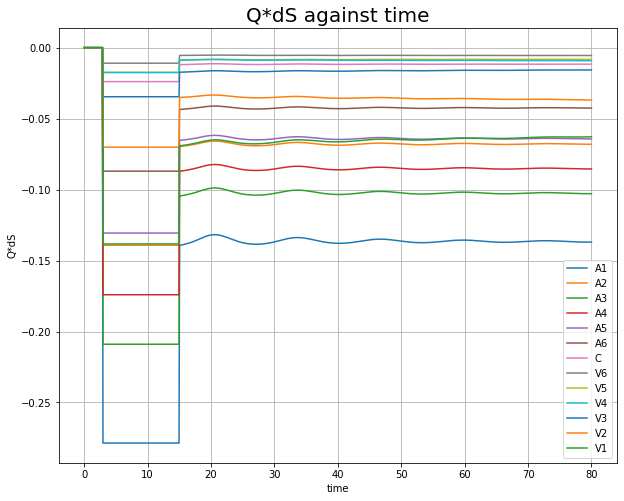

In [47]:
Q_dS = pd.DataFrame({'A1': np.zeros(len(vessel_data_alltime)), 'A2': np.zeros(len(vessel_data_alltime)), 'A3': np.zeros(len(vessel_data_alltime)), 'A4': np.zeros(len(vessel_data_alltime)), 'A5': np.zeros(len(vessel_data_alltime)), 'A6': np.zeros(len(vessel_data_alltime)), 'C': np.zeros(len(vessel_data_alltime)), 'V6': np.zeros(len(vessel_data_alltime)), 'V5': np.zeros(len(vessel_data_alltime)), 'V4': np.zeros(len(vessel_data_alltime)), 'V3': np.zeros(len(vessel_data_alltime)),
           'V2':np.zeros(len(vessel_data_alltime)), 'V1': np.zeros(len(vessel_data_alltime))})

for i in range(len(terms_alltime)):
    for j in range(len(terms_alltime[0])):
        Q_dS.iloc[i,j] = terms_alltime[i].loc[j,'Q_S_diff']
        
f1,a1 = plt.subplots(figsize=(10,8))
for i in range(13):
    plt.plot(t,Q_dS.iloc[:,i], label=terms_alltime[0].loc[i,'Name'])    
a1.legend()
plt.grid(which='both')
plt.ylabel('Q*dS')
plt.xlabel('time')
plt.title('Q*dS against time', fontsize=20)

In [28]:
constants

,Name,Number,Diameter(µm),Length(µm),Viscocity(mPAs),Resistance for U,U in single(m/s????),baseline Q,Vt
0,A1,1,23.97,1267.6,1.59,112.251787,0.061736,27.859025,78005.271056
1,A2,2,19.17,930.3,1.50,121.512242,0.048308,13.942870,39040.035790
2,A3,4,15.28,543.6,1.42,105.796442,0.037997,6.967734,58528.968018
3,A4,8,12.08,302.3,1.34,88.829876,0.030395,3.483601,48770.419868
4,A5,16,9.46,161.2,1.28,73.780690,0.024668,1.733807,36409.953497
5,A6,32,7.32,154.7,1.23,113.637911,0.020680,0.870275,24367.708781
6,C,64,8.00,243.9,1.24,302.436000,0.008663,0.435449,6705.920215
7,V6,32,11.51,473.9,1.33,152.243122,0.008342,0.867974,3037.907970
8,V5,16,14.53,272.3,1.40,57.782247,0.010557,1.750477,4901.336835
9,V4,8,17.79,426.6,1.48,63.838202,0.013941,3.465382,4851.535027


In [29]:
baseline

,Name,Number,Diameter(µm),Length(µm),Pressure Drop(mmHg),Saturation in,Saturation out,Resistance for Q,dS,Saturation ave,Vt,partial pressure blood(mmHg),X-Area wall(mm^2?),wall thickness(µm),tissue partials(mmHg)
0,A1,1,23.97,1267.6,6.93,0.9400,0.9300,0.248752,0.0100,0.93500,78005.271056,68.843131,438.213672,4.841407,66.469317
1,A2,2,19.17,930.3,5.87,0.9300,0.9200,0.421004,0.0100,0.92500,39040.035790,65.327798,313.016429,4.253658,63.549400
2,A3,4,15.28,543.6,4.02,0.9200,0.8900,0.576945,0.0300,0.90500,58528.968018,59.809062,228.546291,3.810683,54.680776
3,A4,8,12.08,302.3,2.70,0.8900,0.8400,0.775060,0.0500,0.86500,48770.419868,52.183980,170.463521,3.485850,43.292757
4,A5,16,9.46,161.2,1.82,0.8400,0.7650,1.049713,0.0750,0.80250,36409.953497,44.546726,130.572935,3.265971,29.653880
5,A6,32,7.32,154.7,2.35,0.7650,0.6650,2.700295,0.1000,0.71500,24367.708781,37.579012,103.110791,3.138293,24.681435
6,C,64,8.00,243.9,2.62,0.6650,0.6100,6.016773,0.0550,0.63750,6705.920215,33.077299,111.338044,3.172168,30.995139
7,V6,32,11.51,473.9,1.27,0.6100,0.5975,1.463178,0.0125,0.60375,3037.907970,31.395007,161.197683,3.433626,31.029776
8,V5,16,14.53,272.3,0.61,0.5975,0.5875,0.348476,0.0100,0.59250,4901.336835,30.861700,214.009514,3.730525,29.979083
9,V4,8,17.79,426.6,0.89,0.5875,0.5825,0.256826,0.0050,0.58500,4851.535027,30.512889,281.309064,4.092089,30.013281


step['dSoutdt'] = 10* (2/(np.pi*((step['Diameter(µm)']**2)/4)*step['Length(µm)']))*((2 * np.pi * K * (step['Diameter(µm)']/2) * vessel_values_general['Length(µm)'])/(step['wall thickness(µm)']*cHb*H)*(step['partial pressure blood(mmHg)']-step['tissue partials(mmHg)']) - step['Q']*(step['Saturation out']-step['Saturation in'])) - step['dSindt']
    